Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as any collaborators you worked with:

In [ ]:
COLLABORATORS = "Nicolette Auld-Griffith, Kate McGrath, Reuben Solnick"

---

In [3]:
from __future__ import print_function
%matplotlib inline
%precision 16
import numpy as numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# HW 6:  ODE Methods - Boundary Value Problems

This homework will combine a lot of previous codes to solve simple linear and non-linear Boundary value problems

This problem set has two questions

## Question 1 - A linear ODE BVP

Consider the *linear* non-homogeneous 2-pt boundary value problem

$$
    u^{\prime\prime}+ u = \sin3x\quad\quad x\in[0,L],\quad u(0)=u(L)=0
$$

which is related to the modes of vibration of a forced string of length $L$.

**(a)** [6] Find an analytic solution to this problem for general $L$ (hint:
  remember your basic ODE's for constant-coefficient problems).  Is
  this solution unique?

 First we solve $$ u^{\prime \prime}(x) + u(x) = 0$$

Characteristic polynomial: $r^2 + 1$

Roots: $r_1 = i, r_2 = -i$

So our general complex solution is $$u(x) = c_1 e^{i x} + c_2 e^{-i x}$$ and our general real solution is $$u(x) = d_1 cos(x) + d_2 sin(x)$$ where $c_{1,2}$ are complex constants  and $d_{1,2}$ are real constants. 


For our particular solution, since we have $sin(3x)$, we can let $$P(x) = A cos (3x) + B sin(3x).$$ $$P^\prime(x) = -3A sin (3x) + 3B cos(3x)$$ $$P^{\prime \prime}(x) = -9A cos (3x) - 9B sin (3x).$$

Substituting into the original equation, we get $$ -9A cos (3x) - 9B sin (3x) + A cos (3x) + B sin(3x) = sin(3x) \Rightarrow -8A cos (3x) - 8B sin (3x) = sin(3x)$$ from which we get $A = 0$ and $B = -\frac{1}{8}$.

Thus our particular solution is $P(x) = -\frac{1}{8} sin(3x)$ and our final solution will take the form of $$u(x) = d_1 cos(x) + d_2 sin(x) -\frac{1}{8} sin(3x). $$

Finally, using our boundaries we see that when $u(0) = 0$, $$u(x) = d_1 cos(x) + d_2 sin(x) -\frac{1}{8} sin(3x) = 0 \Rightarrow d_1 = 0$$

and when $u(L) = 0$, $$u(L) = d_1 cos(L) + d_2 sin(L) -\frac{1}{8} sin(3L) = 0 \Rightarrow d_2 sin(L) -\frac{1}{8} sin(3L) = 0 \Rightarrow d_2 sin(L) = \frac{1}{8} sin(3L) \Rightarrow d_2 = \frac{sin(3L)}{8 sin(L)}.$$

Our solution is now $$u(x) = \frac{sin(3L)}{8 sin(L)}sin(x) -\frac{1}{8} sin(3x)$$

All of the derivatives of the coefficients are unique, therefore we can say that this solution is unique.

**(b)** [4]  create a function `u_true(x,L)` and plot your solution for $L=10$ evaluated on a regularly spaced set of points $\mathbf{x}$

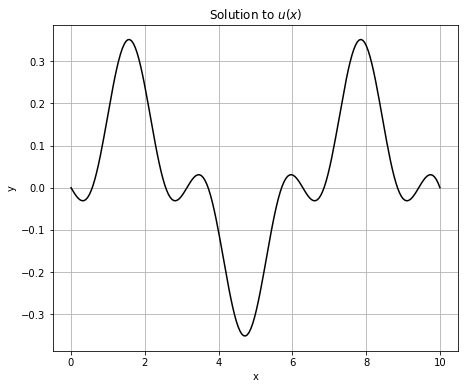

In [6]:
L = 10.
N = 200
x = numpy.linspace(0., L, N)

a = 0.0 
b = 10 
u_a = 0.0
u_b = 0.0
u_true = lambda x: ((numpy.sin(3*L))/(8*numpy.sin(L)))*(numpy.sin(x))- ((1/8)*numpy.sin(3*x))
f = lambda x: -numpy.sin(3*x) - u_true 

x_bc = numpy.linspace(a, b, N+2) 
x = x_bc[1:-1]
#delta_x

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1,2,1)
axes.plot(x_bc, u_true(x_bc), 'k', label = "True")
axes.set_title("Solution to $u(x)$")
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.grid()


**(b)** [8] Write a general shooting algorithm that combines the two scipy routines

* scipy.integrate.solve_ivp
* scipy.optimized.root_scalar

and returns the solution evaluated at an evenly spaced set of points $\mathbf{x}$.  

Some hints

* use `dense_output = True` in solve_ivp
* you can introduce a second def within shoot_bvp for use in root_scalar

For convenience (and testing), I've provided the interface introduced in class for a routine that can handle a range of boundary conditions and can control relative and absolute tolerance.

In [1]:
#  write a general shooting algorithm

from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol=1.e-5, atol=1.e-9):
    """
    Solve the two-point boundary value problem on the interval x\in [a,b], using a shooting method that combines 
        scipy.integrate.solve_ivp and scipy.optimize.root_scalar and allows a range of boundary conditions
        
        
    parameters:
    -----------
    f: calleable 
        vector value function for righthand side of the ODE with interface f(t,u). returns ndarray of length 2
    x: numpy array
        coordinates array for solution  on interval [a,b] with x[0] = a, x[-1] = b
    u_a:  numpy array (length 2)
        provide initial boundary conditions  [u, u' ] at x=a
    u_b:  numpy array (length 2)
        target boundary condition at x = b
    i_a: integer
        index of known boundary condition at x = a.  i.e.
        if dirichlet conditions : i_a = 0 and u(a) is known  
        if neumann conditions   : i_a = 1 and u'(a) is known
        the complementary index is adjusted to match the boundary condition at b
    i_b: integer
        index of known boundary condition at x = b. i.e.
        if dirichlet conditions : i_b = 0 and u(b) is known  
        if neumann conditions   : i_b = 1 and u'(b) is known
        the complementary index is ignored at b
    rtol:  float
        relative tolerance
    atol:  float
        absolute tolerance
        
    returns:
    --------
    u: solution u(x) for x (uses dense_output from solve_ivp to interpolate solution onto x)
    """

'''u
u_a = u(0) 
u_b = u(L)

u(0) = u(L) = 0 
f = []
x = numpy.array[]'''



a = x[0]
b = x[-1]

def udiff(x): 
    '''
    Solves IVP using solve_ivp. Has adjustable IC u_var and returns the difference (which we want to go to zero) between sol.y[ib] - u_b[ib]

'''
    if ia == 0: 
        initial == [u_a[0], u_var]
    elif ia == 1: 
        initial = [u_var, u_a[1]]
    
    sol= sol.solve_ivp(f, [a, b], initial, dense_output = True, rtol= rtol, atol = atol) 
    
    return sol.sol(x)[0]
        
        
        
    



SyntaxError: unexpected EOF while parsing (<ipython-input-1-05cc379d7e83>, line 103)

**(c)** [4] rewrite the original problem 

$$
    u^{\prime\prime} + u = \sin(3x)
$$

as a system of first order ODE's

$$
    \frac{d\mathbf{v}}{dx} = \mathbf{f}(x,\mathbf{v})
$$  

and solve using the interface

`u_sol = shoot_bvp(f, x, u_a, u_b, i_a, i_b)`

* make a plot comparing your shooting solution with the true solution.

The following cell tests your shooting code against the true solution.  Adjust the relative and absolute tolerances in shoot_bvp, to make sure the following test passes with relative error $<10^{-6}$

In [ ]:
#  test the solution against the true solution and pass if relative error < 1.e-6

rel_err = numpy.linalg.norm(u_sol - u_true(x,L))/numpy.linalg.norm(u_true(x,L))
print('relative error = {}'.format(rel_err))

assert(rel_err < 1.e-6)
print('success')

**(d)** [8] Repeat the exercise but use the 2nd order finite difference methods introduced in class.  For convenience I have provided the routines for assembly of sparse 2nd derivative matrices and RHS from class.  

In [1]:
# routines from class  for generating 2nd order sparse second derivative operator and RHS vector

from fdcoeffV import fdcoeffV
from scipy.sparse import lil_matrix, identity, spdiags
from scipy.sparse.linalg import spsolve


def D2(x,bcs=['dirichlet', 'dirichlet']):
    """  
        Assemble a general sparse second-order finite-difference approximation to d/dx^2 on a possibly irregular mesh
        First and last rows are set by string bcs
        
        parameters:
        -----------
        x: numpy.array
            mesh coordinates
        bcs: list of strings for boundary conditions e.g [left_string, right_string] where
            the strings can be either 'dirichlet' or 'neumann'
    """
    N = len(x)
    A = lil_matrix((N,N))
    if bcs[0] == 'dirichlet':
        A[0,0] = 1.
    elif bcs[0] == 'neumann':
        A[0,0:3] = fdcoeffV(1,x[0],x[:3])
    else:
        raise ValueError('no known BC type for left boundary {}'.format(bcs[0]))
        
    if bcs[1] == 'dirichlet':
        A[-1,-1] = 1.
    elif bcs[1] == 'neumann':
        A[-1,-3:] = fdcoeffV(1,x[-1],x[-3:])
    else:
        raise ValueError('no known BC type for right boundary {}'.format(bcs[1]))
        
    for i in range(1,N-1):
        A[i, i-1:i+2] = fdcoeffV(2, x[i], x[i-1:i+2] )        
    return A.tocsr()

def RHS(x, f, bvalues):
    """ Set the rhs vector
    
        parameters
        ----------
        x: numpy.array
            mesh coordinates
        f: callable
            rhs function for interior points called on f(x[1:-2])
        bvalues:  numpy.array (len 2)
            values for boundary conditions (either dirichlet or neumann)        
    """
    
    N = len(x)
    rhs = numpy.empty(N)
    rhs[[0, N-1]] = bvalues
    rhs[1:-1] = f(x[1:-1])
    
    return rhs


L = 10.
N = 100 
a = 0. 
b = L 
x = numpy.linspace(a,b,N) 
# how to include the u part on rhs? 
D= D2(x)
A = D + numpy.identity(D.size[0]) 
rhs_fun = lambda x: numpy.sin(3*x)
f = RHS(x, rhs_fun, [0., 0.])

u= spsolve(A,f) 
u_true = lambda x: ((numpy.sin(3*L))/(8*numpy.sin(3*L)))*(numpy.sin(x))- ((1/8)*numpy.sin(3*x))

#plot result
# Plot result
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(x, u, 'o', label="Computed")
axes.plot(x, u_true(x), 'k', label="True")
axes.set_title("Solution to $u_{xx} = sin(3*x) - u(x)$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")
axes.grid()

axes = fig.add_subplot(1, 2, 2)
err = numpy.abs(u - u_true(x))
axes.plot(x, err, 'ro-')
axes.set_title("Absolute Error")
axes.set_xlabel('x')
axes.set_ylabel('err')
axes.grid()
plt.show()



    

NameError: name 'numpy' is not defined

Create a well-labeled convergence plot showing the relative error 

$$
    e_{rel} = \frac{|| u - u_{true} ||}{||u_{true}||}
$$

as a function of grid spacing $\Delta x$

This plot should calculate and show

* rate of convergence of error (i.e. find $p$ such that $e_{rel}\propto \Delta x^p$)
* an estimate of the  number of grid points $N$ required for the relative error to be $\leq 10^{-6}$
* the relative error at this smallest mesh spacing

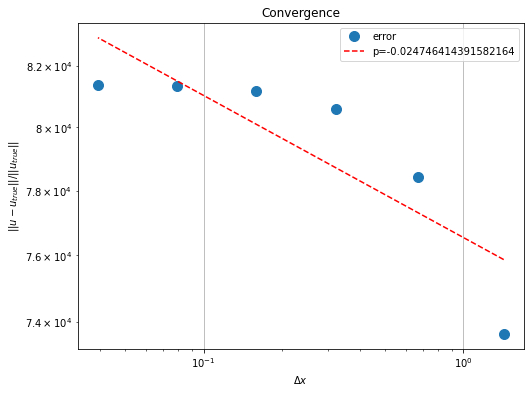

In [40]:
L = 10.
u_true = lambda x: ((numpy.sin(3*L))/(8*numpy.sin(3*L)))*(numpy.sin(x))- ((1/8)*numpy.sin(3*x))

N = [ 2**n for n in range(3,9) ]
rel_err = numpy.empty(len(N))
delta_x = numpy.empty(len(N))

for i,n in enumerate(N):
    x = numpy.linspace(a, b, n)
    A = D2(x)
    f = RHS(x, numpy.exp, [0., 3. ])
    u = spsolve(A,f)
    rel_err[i] = numpy.linalg.norm(u - u_true(x))/numpy.linalg.norm(u_true(x))
    delta_x[i] = x[1] - x[0]
    
# calculate best fit slope and Plot result
p = numpy.polyfit(numpy.log(delta_x),numpy.log(rel_err),1)
dx = numpy.logspace(numpy.log10(delta_x[0]),numpy.log10(delta_x[-1]),100)
err = numpy.exp(p[1])*dx**p[0]
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.loglog(delta_x, rel_err, 'o',label='error', markersize=10 )
axes.loglog(dx,err,'r--',label="p={}".format(p[0]))
axes.set_title("Convergence")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$||u - u_{true}||/||u_{true}||$")
axes.legend(loc='best')
axes.grid()


### Some themes and variations

This is meant to be a short problem set, but there are many other things to try if you are interested.

* Try this problem using Galerkin Finite Elements.  
* Try modifying the matrices to use higher order Finite difference schemes (i.e. 4th order schemes)
* Compare timing between Finite Difference and shooting schemes for the same order of accuracy


## Question 2 - Non-Linear Fun

try to solve the related  **non-linear** 2-point boundary value problem

$$
u^{\prime\prime}+\sin(u)=\sin(3x),\quad x\in[0,10],\quad u(0)=u(10)=0
$$

using  finite-difference plus Newton's method. For convenience, I've added the Newton Solver for sparse jacobians from the notes

In [ ]:
 

# a Newton Solver for sparse matrices
def newton(F,J,x0,tol=1.e-6,MAX_ITS=100,verbose=True):
    """ Solve F(x) = 0 using Newton's method until ||F(x)|| < tol or reaches Max iterations
    
    Params:
    -------
        F: calleable: 
            Function returning residual F(x)
        J: calleable
            Function returning Jacobian J(x)
        tol: float
            stopping criteria for ||F|| < tol
        MAX_ITS: integer
            maximum number of iterations
        verbose: bool
            if true spits out norm of the residual at each iteration
            
    Returns:
    --------
        x: numpy.array
            solution
        k: int
            number of iterations
    
    Raises:
    -----------
        ValueError if number of its exceeds MAX_ITS
        
    """
    
    
    x = x0 
    for k in range(MAX_ITS+1):
        res = numpy.linalg.norm(F(x))
        if verbose:
            print('k = {}, ||F|| = {}'.format(k,res))
        if res < tol: 
            return x, k
        delta = spsolve(J(x),-F(x))
        x += delta
        
    raise ValueError('Maximum number of iterations exceeded {}'.format(MAX_ITS))

**(a)** [4 pt]  Solve the problem for an initial guess
$u_0=0$. For this problem you will need to

* create a function to return the residual $\mathbf{F}(\mathbf{u})$
* create a function to return the Jacobian $J(\mathbf{u})$
* use `verbose=True` to see the convergence behavior of Newton
* produce a plot showing the solution and labeled with the number of newton iterations and final residual norm $||\mathbf{F}(\mathbf{u})||$

**Note:**  To choose a reasonable number of grid points, use your results from Question 1 and choose a mesh size such that the linear problem returns a relative error $< 10^{-3}$

k = 0, ||F|| = 7.018234873694742
k = 1, ||F|| = 0.028523832398621503
k = 2, ||F|| = 0.0008117645335269754
k = 3, ||F|| = 1.1013791773710535e-06
k = 4, ||F|| = 2.1367025797473768e-12


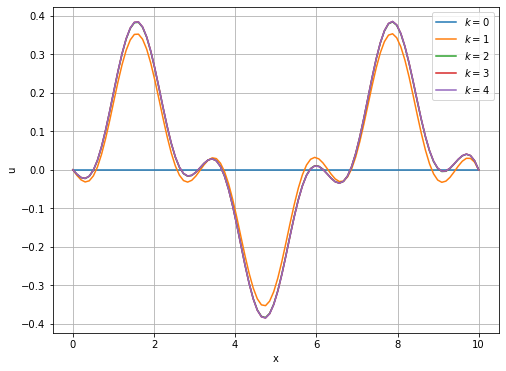

In [37]:
from fdcoeffV import fdcoeffV
from scipy.sparse import lil_matrix, identity, spdiags
from scipy.sparse.linalg import spsolve


# a Newton Solver for sparse matrices
def newton(F,J,x0,tol=1.e-6,MAX_ITS=100,verbose=True):
    """ Solve F(x) = 0 using Newton's method until ||F(x)|| < tol or reaches Max iterations
    
    Params:
    -------
        F: calleable: 
            Function returning residual F(x)
        J: calleable
            Function returning Jacobian J(x)
        tol: float
            stopping criteria for ||F|| < tol
        MAX_ITS: integer
            maximum number of iterations
        verbose: bool
            if true spits out norm of the residual at each iteration
            
    Returns:
    --------
        x: list
            list of points for each Newton iteration (just used for plotting intermediate results)
            the solution is x[-1]
    Raises:
    -----------
        ValueError if number of its exceeds MAX_ITS
        
    """
    x = [ x0 ]
    for k in range(MAX_ITS+1):
        xk = x[k]
        res = numpy.linalg.norm(F(xk))
        if verbose:
            print('k = {}, ||F|| = {}'.format(k,res))
        if res < tol: 
            return numpy.array(x), k
        delta = spsolve(J(xk),-F(xk))
        x.append( xk + delta)
        
        
                
    raise ValueError('Maximum number of iterations exceeded {}'.format(MAX_ITS))

def D2(x,bcs=['dirichlet', 'dirichlet']):
    """  
        Assemble a general sparse second-order finite-difference approximation to d/dx^2 on a possibly irregular mesh
        First and last rows are set by string bcs
        
        parameters:
        -----------
        x: numpy.array
            mesh coordinates
        bcs: list of strings for boundary conditions e.g [left_string, right_string] where
            the strings can be either 'dirichlet' or 'neumann'
    """
    N = len(x)
    A = lil_matrix((N,N))
    if bcs[0] == 'dirichlet':
        A[0,0] = 1.
    elif bcs[0] == 'neumann':
        A[0,0:3] = fdcoeffV(1,x[0],x[:3])
    else:
        raise ValueError('no known BC type for left boundary {}'.format(bcs[0]))
        
    if bcs[1] == 'dirichlet':
        A[-1,-1] = 1.
    elif bcs[1] == 'neumann':
        A[-1,-3:] = fdcoeffV(1,x[-1],x[-3:])
    else:
        raise ValueError('no known BC type for right boundary {}'.format(bcs[1]))
        
    for i in range(1,N-1):
        A[i, i-1:i+2] = fdcoeffV(2, x[i], x[i-1:i+2] )        
    return A.tocsr()

N = 100 
x = numpy.linspace(0., 10., N)
A = D2(x) 

#use notes and set dirichlet conditions
def F(u): 
    f = A.dot(u) + numpy.sin(u) - numpy.sin(3*x)
    #set residual go to zero 
    f[[0,-1]] = 0 
    return f
    
    
# set the Jacobian 
def J(u): 
    n = len(u) 
    return A + spdiags(numpy.cos(u),0, n, n) 

#initial guess use a straight line with correct boundary conditions 

u0 = numpy.linspace(0., 0., N)
sol,its = newton(F,J,u0, verbose = True) 

plt.figure(figsize=(8,6))
for k in range(its+1): 
    plt.plot(x, sol[k], label = '$k={}$'.format(k))
axes.plot(x, sol[its], label = "$F(u)$")
plt.grid()
plt.legend(loc = 'best') 
plt.xlabel('x')
plt.ylabel('u')
plt.show()


# du 

**(b)**  Is your solution unique?  Try starting newton from different
  periodic initial conditions 
  
  $$
      u_0(x) = \sin\left[\frac{n\pi x}{L}\right]
  $$ 
  
  for $n\in[0,6]$ that all satisfy the homogeneous boundary conditions. 
  
  Make two plots. 
  
  1. The first shows solutions for different values of $n$
  1. The second plots the residual $\mathbf{F}(\mathbf{u})$ to show that at least the discrete ODE is satisfied
  
 Welcome to the wonderful world of non-linear equations. Can you find any other solutions?

In [32]:
N = 100 
x = numpy.linspace(0., 10., N)
A = D2(x) 
n = numpy.linspace(0, 6, N)

#use notes and set dirichlet conditions
def F(u): 
    f = A.dot(u) + numpy.sin(u) - numpy.sin(3*x)
    #set residual go to zero 
    f[[0,-1]] = 0 
    return f
    
    
# set the Jacobian 
def J(u): 
    n = len(u) 
    return A + spdiags(numpy.cos(u),0, n, n) 

#initial guess use a straight line with correct boundary conditions 

u0 = numpy.linspace(0., numpy.sin((n*numpy.pi*x)/10), N) 
sol,its = newton(F,J,u0, verbose = True) 

plt.figure(figsize=(8,6))
for k in range(its+1): 
    plt.plot(x, sol[k], label = '$k={}$')
plt.grid()
plt.legend(loc = 'best') 
plt.xlabel('x')
plt.ylabel('u')
plt.show()




k = 0, ||F|| = 73.67253781084511


ValueError: number of diagonals (100) does not match the number of offsets (1)

### Extra Fun

Use your shooting routines to systematically search for non-linear solutions to this BVP problem by varying the initial guess for the initial slope $u'(0)$. How many solutions can you find?